<a href="https://colab.research.google.com/github/Ninja7328/ML-Practicing/blob/main/Anomaly_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [2]:
from sklearn.model_selection import train_test_split
#The last element contains the labels
labels = raw_data[:, -1]

#The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [3]:
#Normalise Data
import tensorflow as tf

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [4]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

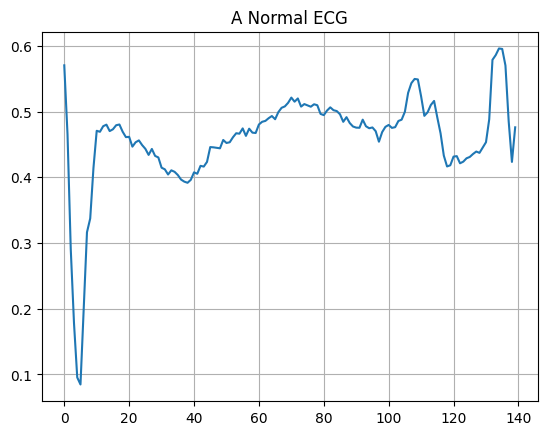

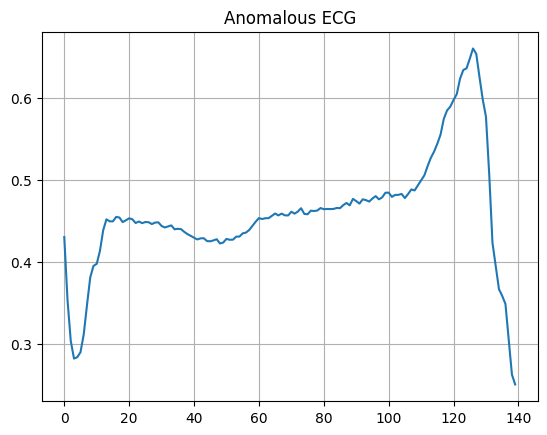

In [5]:
#Visualise
import matplotlib.pyplot as plt
import numpy as np

plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("Anomalous ECG")
plt.show()

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu")
    ])
    self.decoder = tf.keras.Sequential([
       layers.Dense(16, activation="relu"),
       layers.Dense(32, activation="relu"),
       layers.Dense(140, activation="sigmoid")
   ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [7]:
autoencoder.compile(optimizer='adam', loss='mae')

#mae=mean absolute error

In [9]:
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=20, batch_size=512, validation_data=(test_data, test_data), shuffle=True)

Epoch 1/20
5/5 [==============================] - 4s 54ms/step - loss: 0.0586 - val_loss: 0.0535
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0564 - val_loss: 0.0518
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0539 - val_loss: 0.0503
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0509 - val_loss: 0.0483
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0471 - val_loss: 0.0465
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0431 - val_loss: 0.0439
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0392 - val_loss: 0.0422
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0403
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0325 - val_loss: 0.0388
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0301 - val_loss: 0.0378
Epoch 11/20
5/5 [============

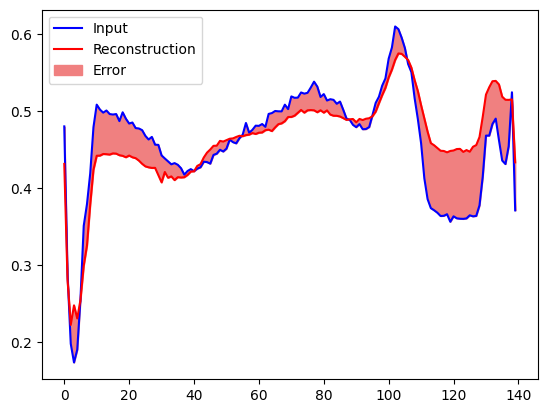

In [10]:
# Visualise

encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input","Reconstruction", "Error"])
plt.show()

74/74 [==============================] - 0s 2ms/step


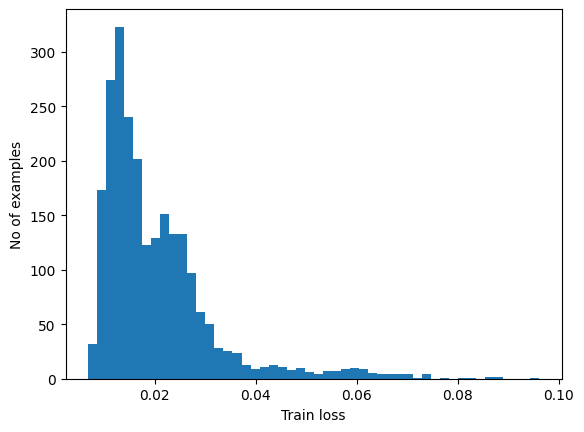

In [12]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [13]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032000892


In [14]:
def anomaly(data):
  predict = autoencoder.predict(np.reshape(data,(-1,1)))
  loss = tf.keras.losses.mae(predict, data)
  if (loss > threshold):
    return "Anomaly"
  else:
    return "Normal"